**Chapter 17 – Autoencoders and GANs**

_This notebook contains some sample codes in chapter 17._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 2s 7ms/step - loss: 0.2726
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1026
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0547
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0773
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2136
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1043
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0315
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0241
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 11/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 13/20
2/2 [==============================] - 0s 8ms/step - loss: 0.

In [6]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


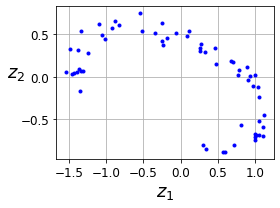

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3815 - rounded_accuracy: 0.8487 - val_loss: 0.3166 - val_rounded_accuracy: 0.9002
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3083 - rounded_accuracy: 0.9127 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2998 - rounded_accuracy: 0.9204 - val_loss: 0.2986 - val_rounded_accuracy: 0.9198
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2959 - rounded_accuracy: 0.9240 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2928 - rounded_accuracy: 0.9268 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2920 - rounded_accuracy: 0.9283 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

In [11]:
stacked_encoder.summary()
stacked_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
____________________________

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [13]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


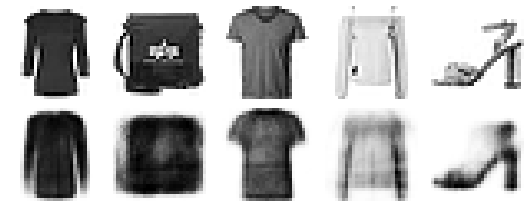

In [14]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing Fashion MNIST

In [15]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

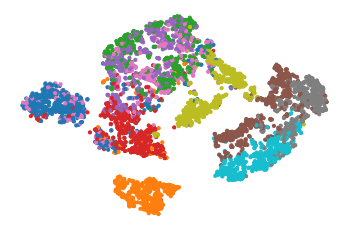

In [16]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


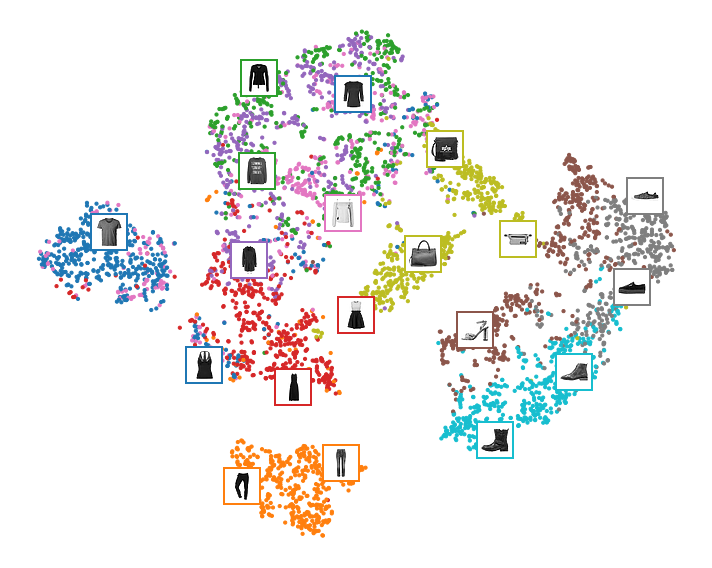

In [17]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 6ms/step - loss: 0.3376 - rounded_accuracy: 0.8895 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 2/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2777 - rounded_accuracy: 0.9392 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 3/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2717 - rounded_accuracy: 0.9451 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 4/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2690 - rounded_accuracy: 0.9483 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 5/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2669 - rounded_accuracy: 0.9505 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00


In [19]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

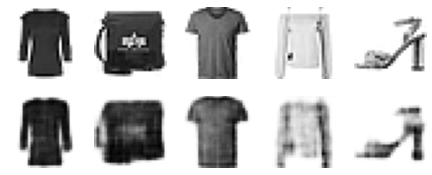

In [20]:
show_reconstructions(conv_ae)
plt.show()

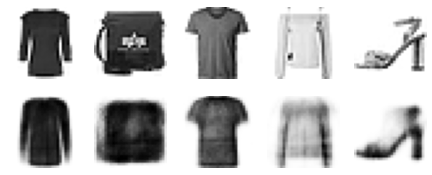

In [21]:
show_reconstructions(stacked_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2), ##########################################
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4007 - rounded_accuracy: 0.8323 - val_loss: 0.3182 - val_rounded_accuracy: 0.9036
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3146 - rounded_accuracy: 0.9075 - val_loss: 0.3087 - val_rounded_accuracy: 0.9156
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3067 - rounded_accuracy: 0.9140 - val_loss: 0.3035 - val_rounded_accuracy: 0.9191
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3032 - rounded_accuracy: 0.9173 - val_loss: 0.2999 - val_rounded_accuracy: 0.9207
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2998 - rounded_accuracy: 0.9205 - val_loss: 0.2968 - val_rounded_accuracy: 0.9252
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2985 - rounded_accuracy: 0.9222 - val_loss: 0.2947 - val_rounded_accuracy: 0.9272
Epoch 7/10
1719/1719 [==================

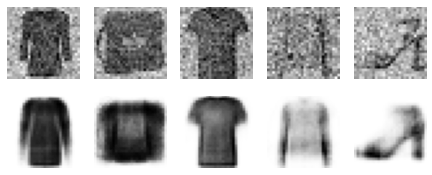

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4073 - rounded_accuracy: 0.8261 - val_loss: 0.3200 - val_rounded_accuracy: 0.9040
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3203 - rounded_accuracy: 0.9017 - val_loss: 0.3126 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3136 - rounded_accuracy: 0.9067 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3102 - rounded_accuracy: 0.9094 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3070 - rounded_accuracy: 0.9121 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3063 - rounded_accuracy: 0.9132 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

Saving figure dropout_denoising_plot


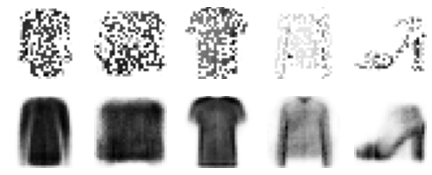

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)